In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
from dce import DCE
from cluster import Cluster
from descriptor import rdkitDescriptors
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

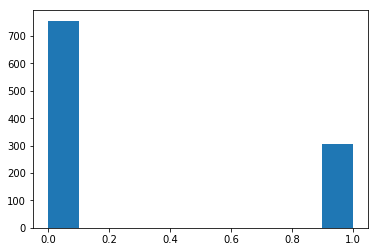

In [2]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])

df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition'])

In [3]:
fps = rdkitDescriptors.batch_compute_rdkit_fingerprints(df['SMILES'])
len(fps[0])

2048

In [4]:
autoencoder_dims = [2048,512,128]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50)
dce.build_model()

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
dce.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 2048)         0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2048)         8192        input[0][0]                      
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 512)          1049088     batch_normalization_1[0][0]      
__________________________________________________________________________________________________
embedding_layer (Dense)         (None, 128)          65664       encoder_0[0][0]                  
__________________________________________________________________________________________________
decoder_1 

In [8]:
cl_weights = np.arange(0.1, 1, 0.1)
results = []

for cl_weight in cl_weights:
    dce.build_model()
    print('Start to train model with cluster weight: ' + str(cl_weight))
    result_i = dce.train_model(fps,clustering_loss='kld', 
                               decoder_loss='binary_crossentropy',
                               training_prints=False,
                               clustering_loss_weight=cl_weight)
    results.append(result_i)
    print('Training finished and the results are recorded')


Start to train model with cluster weight: 0.1
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.2
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.30000000000000004
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.4
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.5
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.6
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.7000000000000001

In [18]:
1 % 3

1

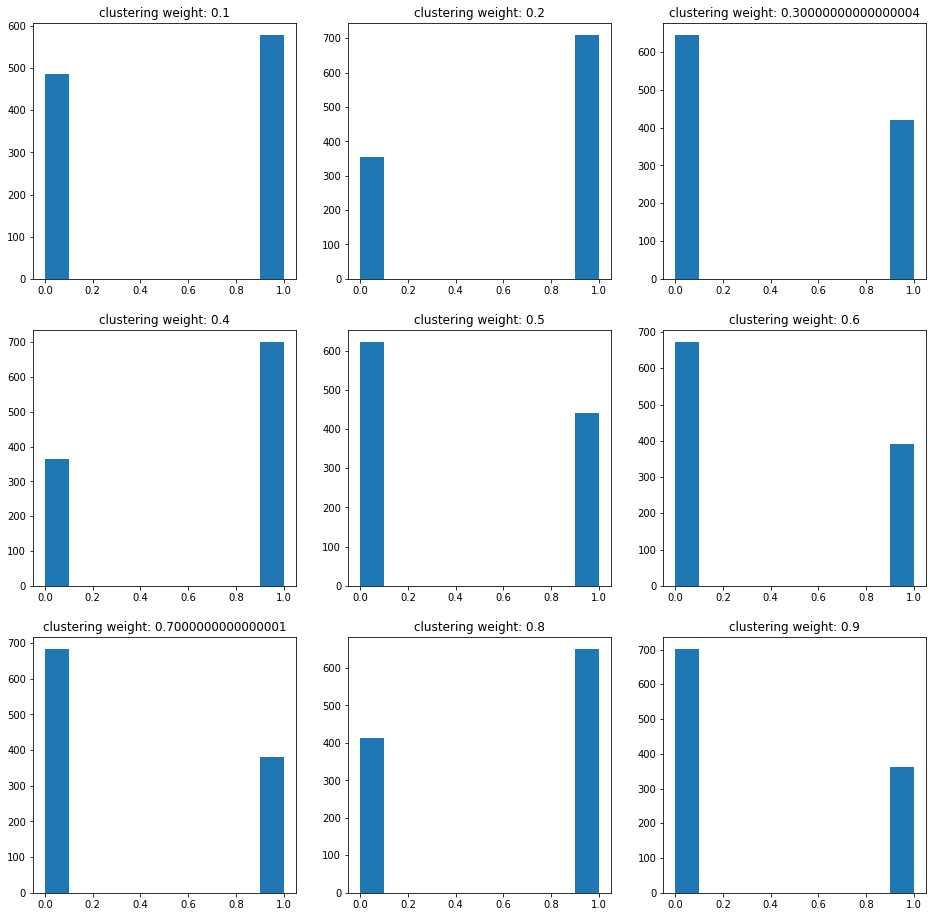

In [20]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    ax[row_i][column_j].hist(results[i][0])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

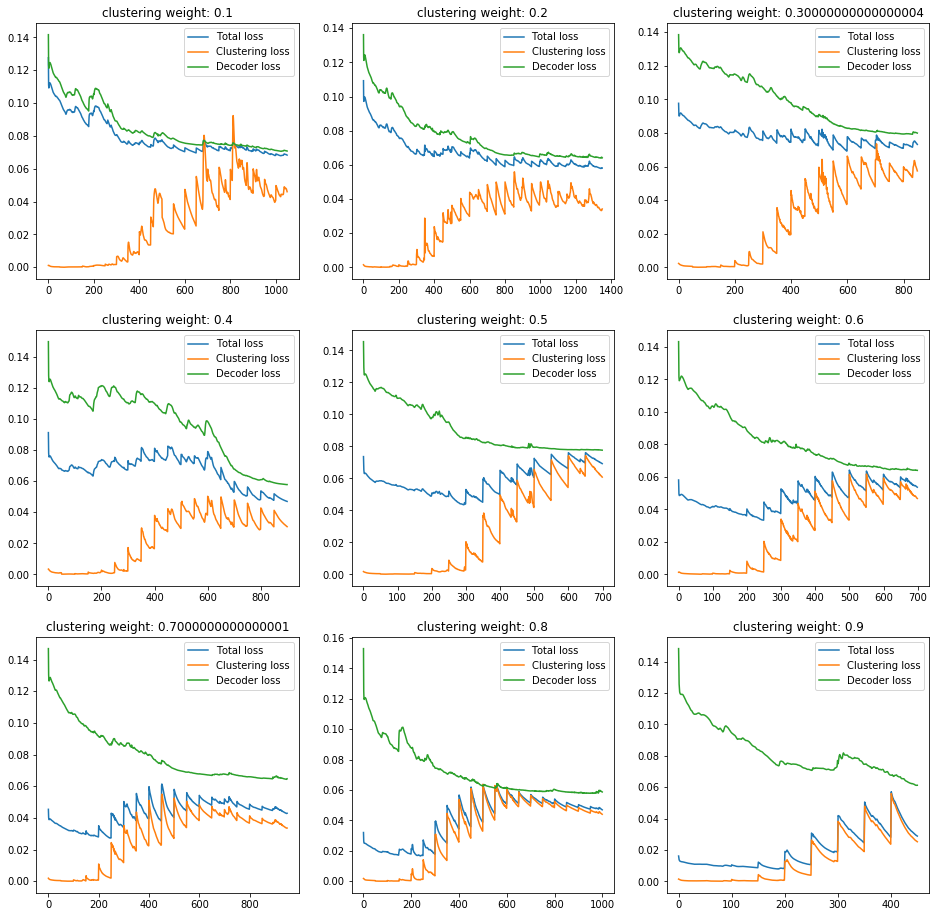

In [21]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    ax[row_i][column_j].plot(results[i][1][0],label='Total loss')
    ax[row_i][column_j].plot(results[i][1][1],label='Clustering loss')
    ax[row_i][column_j].plot(results[i][1][2],label='Decoder loss')
    ax[row_i][column_j].legend()
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))


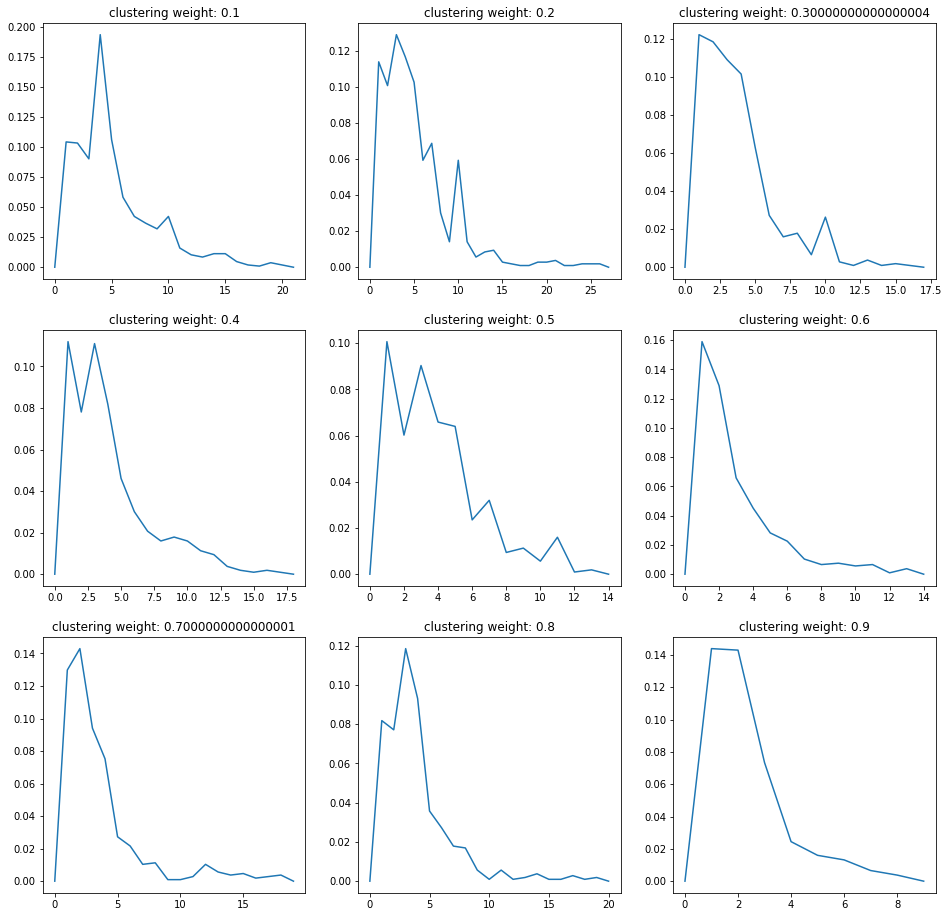

In [22]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    ax[row_i][column_j].plot(results[i][2])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

Text(0.5, 1.0, 'fowlkes_mallows_score')

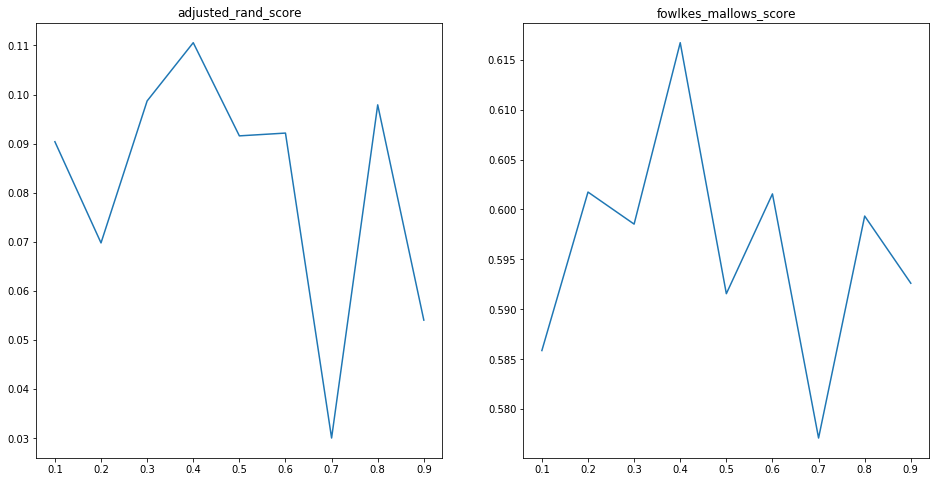

In [25]:
adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(true_label_biclass,results[i][0],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

fig, ax =plt.subplots(1,2,figsize=(16,8))

ax[0].plot(cl_weights,adjusted_rand_score)
ax[0].set_title('adjusted_rand_score')

ax[1].plot(cl_weights,fowlkes_mallows_score)
ax[1].set_title('fowlkes_mallows_score')